# MODNet 'matbench_steels' benchmarking

The `matbench_steels` dataset from [Citrination](https://citrination.com/datasets/153092/) (contributed by Gareth Conduit, University of Cambridge) contains the composition of ~800 steels and some measured properties with variable coverage. The dataset `matbench_steels` as made available by matminer has de-duplicated the steels down to ~312 samples, and provides only the measured yield strength, the property with 100% coverage.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



## Data exploration

In [2]:
df = load_dataset("matbench_steels")
df["composition"] = df["composition"].map(Composition)

In [3]:
df.columns

Index(['composition', 'yield strength'], dtype='object')

### Composition space

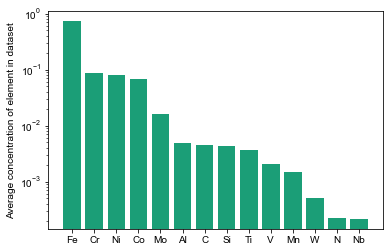

In [4]:
values = df["composition"].apply(lambda s: s.get_el_amt_dict())
elements = defaultdict(float)
proportions = defaultdict(list)
for s in values:
    for e in s:
        elements[e] += s[e]
        proportions[e] += [s[e]]
        
for elem in elements:
    elements[elem] /= len(values)

mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True))
elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(facecolor="w");
ax.set_yscale("log")
ax.bar(elements.keys(), elements.values())
ax.set_ylabel("Average concentration of element in dataset");

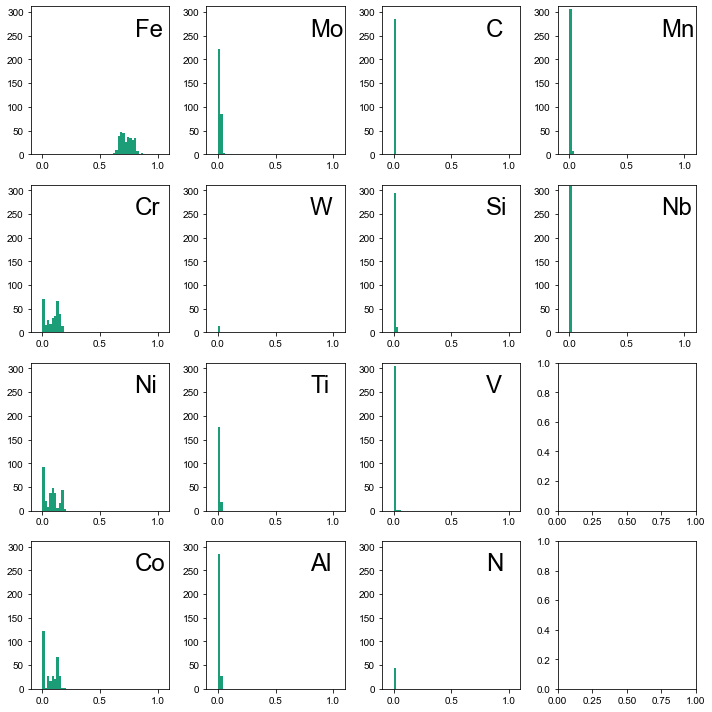

In [5]:
# distribution of element proportions across compositions
fig, ax = plt.subplots(4, 4, facecolor="w", figsize=(10, 10))
for axis, elem in zip(itertools.product(range(0, 4), repeat=2), mean_proportions):
    axis = (axis[1], axis[0])
    ax[axis].hist(
        proportions[elem], 
        bins=np.linspace(0, 1, 50), 
        density=False, 
    )
    ax[axis].set_xlim(-0.1, 1.1)
    ax[axis].text(0.75, 0.8, elem, fontsize=24, transform=ax[axis].transAxes, )
    ax[axis].set_ylim(0, 312)

plt.tight_layout()

### Target space

In [6]:
df.describe()

,yield strength
count,312.000000
mean,1420.998397
std,301.894169
min,1005.900000
25%,1219.475000
50%,1344.200000
75%,1576.075000
max,2510.300000


Text(0.5, 0, 'Yield strength (GPa)')

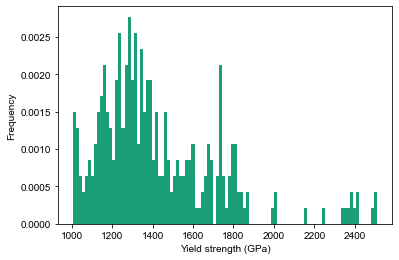

In [7]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["yield strength"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("Yield strength (GPa)")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [8]:
class CompositionOnlyFeaturizer(MODFeaturizer):
    composition_featurizers = DeBreuck2020Featurizer.composition_featurizers
    
    def featurize_composition(self, df):
        """ Applies the preset composition featurizers to the input dataframe,
        renames some fields and cleans the output dataframe.

        """
        from pymatgen.core.periodic_table import Element 
        import numpy as np
        from modnet.featurizers import clean_df
        df = super().featurize_composition(df)
        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        df['AtomicOrbitals|HOMO_character'] = df['AtomicOrbitals|HOMO_character'].map(_orbitals)
        df['AtomicOrbitals|LUMO_character'] = df['AtomicOrbitals|LUMO_character'].map(_orbitals)

        df['AtomicOrbitals|HOMO_element'] = df['AtomicOrbitals|HOMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )
        df['AtomicOrbitals|LUMO_element'] = df['AtomicOrbitals|LUMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )

        df = df.replace([np.inf, -np.inf, np.nan], 0)
        
        return clean_df(df)

class CompositionContainer:
    def __init__(self, composition):
        self.composition = composition

In [9]:
PRECOMPUTED_MODDATA = "./precomputed/steel_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_steels")
    df["composition"] = df["composition"].map(Composition)
    df["structure"] = df["composition"].map(CompositionContainer)
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["yield strength"].tolist(), 
        target_names=["yield strength (MPa)"],
        featurizer=CompositionOnlyFeaturizer(n_jobs=8)
    )
    data.featurize()
    # As this is a small data/feature set, order all features 
    data.feature_selection(n=-1)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f3415467410> object, created with modnet version 0.1.8~develop


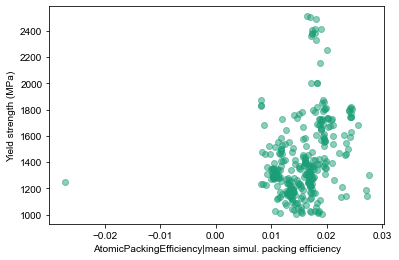

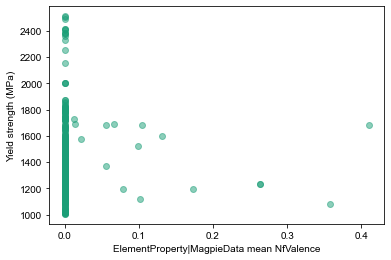

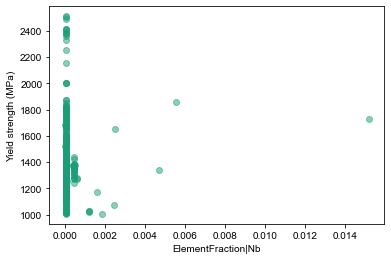

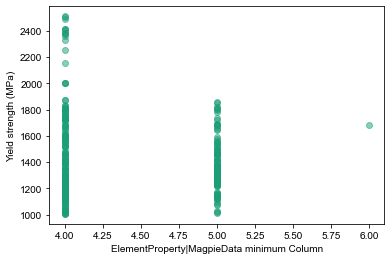

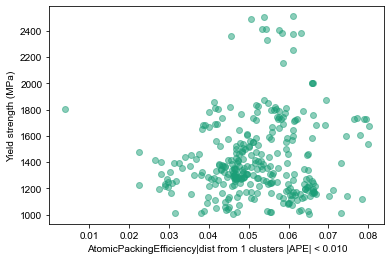

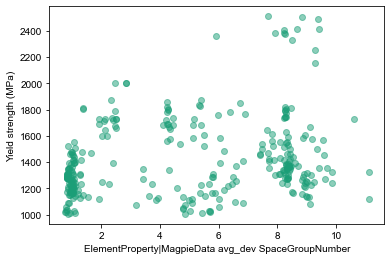

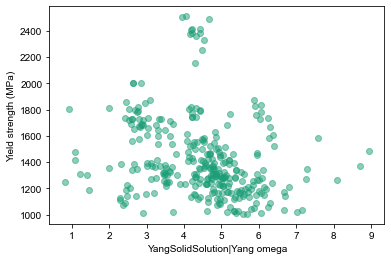

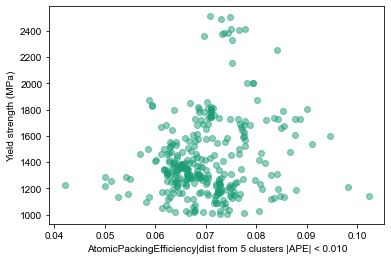

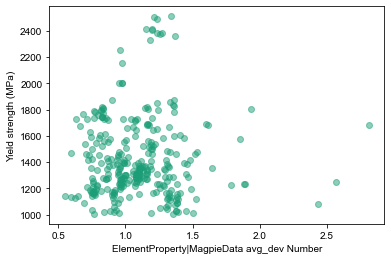

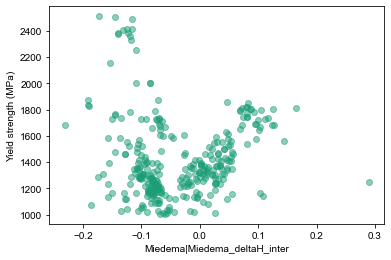

In [10]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("Yield strength (MPa)")

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [11]:
def benchmark(model, data):
    import seaborn as sns
    predictions = model.predict(data)
    errors = np.abs(predictions.values - data.df_targets.values)
    fig, ax = plt.subplots(facecolor="w")
    ax.hist(errors, bins=100)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Absolute error (MPa)")
    ax.axvline(95.2, ls='--', color='k', label="Automatminer RF")
    ax.axvline(np.mean(model.history.history["val_mae"]), 0, 1, ls='--', color='r', label="Validation MAE")
    ax.axvline(np.mean(errors), ls='--', color='b', label="Test MAE")
    ax.legend()
    
    fig, ax = plt.subplots(facecolor="w")
    ax.scatter(data.df_targets.values, predictions.values, alpha=0.25)
    ax.plot(np.linspace(*plt.xlim(), 2), np.linspace(*plt.xlim(), 2))
    sns.regplot(x=data.df_targets.values, y=predictions.values, ax=ax)
    ax.set_xlabel("$\\sigma_\\mathrm{true}$")
    ax.set_ylabel("$\\sigma_\\mathrm{pred.}$")
    ax.text(0.75, 0.5, f"Test MAE: {np.mean(errors):3.1f} MPa", transform=ax.transAxes,)
    
    fig, ax = plt.subplots(facecolor="w")
    ax.plot(model.history.history["val_mae"][10:])
    ax.axhline(95.2, ls='--', color="k", label="Automatminer RF")
    ax.set_ylim(np.mean(errors)*0.5, np.mean(errors)*1.5)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation MAE (MPa)")

In [12]:
from sklearn.model_selection import KFold
from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

MATBENCH_SEED = 18012019

kf = KFold(n_splits=5, shuffle=True, random_state=MATBENCH_SEED)
kf_splits = kf.split(data.df_featurized, y=data.df_targets)

verbose = False

callbacks = [
    ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, mode="auto", min_delta=0.0, verbose=verbose), 
    EarlyStopping(monitor="loss", min_delta=0.01, patience=300, mode="auto", baseline=None, restore_best_weights=True, verbose=verbose)
]

data.df_targets.rename(columns={"yield strength (GPa)": "sigma"}, inplace=True)

best_models = []

for train, test in kf_splits:
    
    train_moddata, test_moddata = data.split((train, test))
    
    model = MODNetModel(
        [[["sigma"]]], 
        {"sigma": 1}, 
        num_neurons=([32], [128], [8], []), 
        n_feat=32,
        act="elu",
    )
    model.fit(
        training_data=train_moddata, 
        batch_size=32, 
        epochs=10000, 
        val_data=test_moddata,
        loss="mae",
        lr=0.005,
        verbose=0,
        callbacks=callbacks
    )
    
    best_models.append(model)

INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


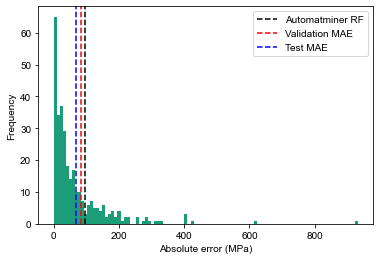

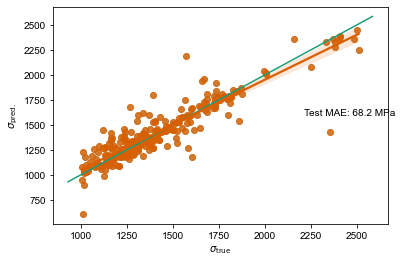

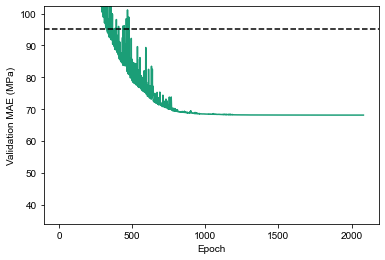

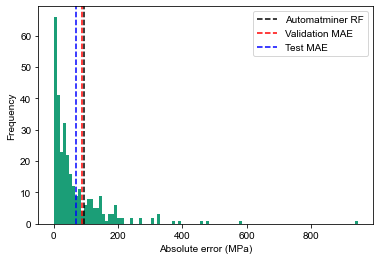

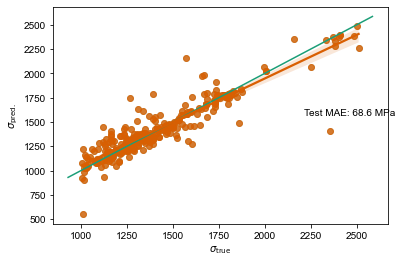

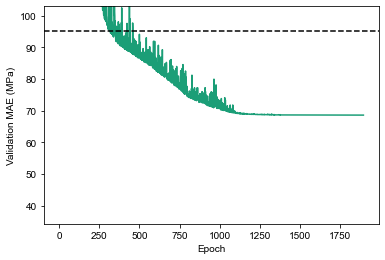

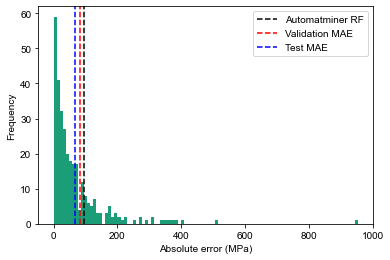

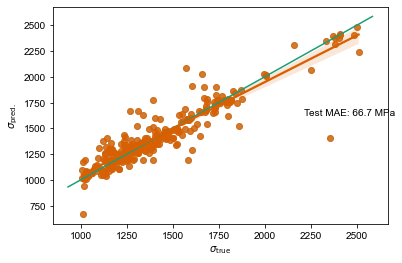

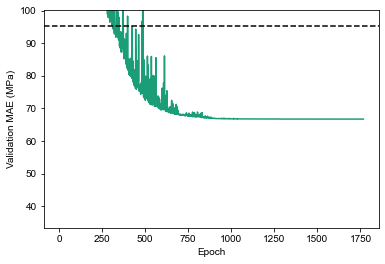

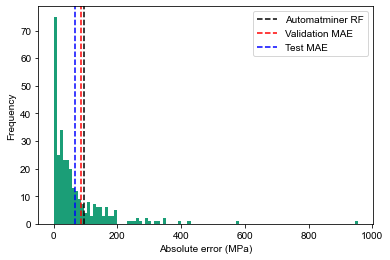

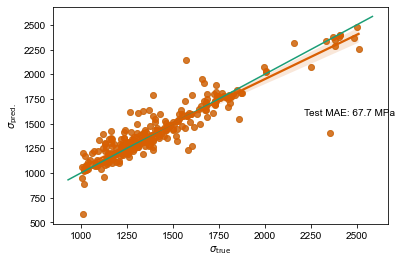

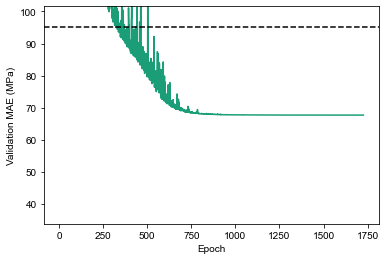

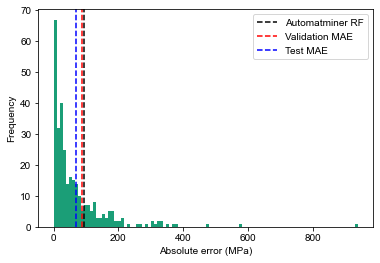

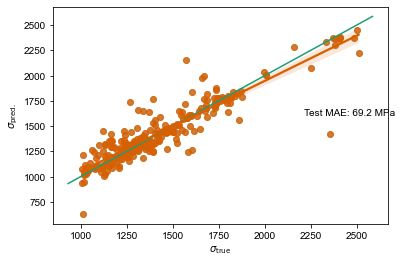

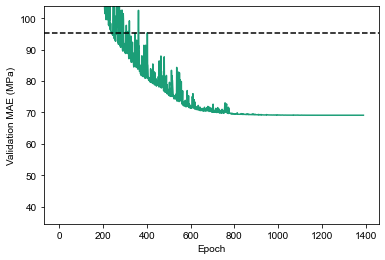

In [13]:
for i in range(5):
    benchmark(best_models[i], data)

INFO:root:Training preset #1/6
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 54979.267
INFO:root:Training preset #2/6
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 218406.958
INFO:root:Training preset #3/6
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 104016.373
INFO:root:Training preset #4/6
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 79120.442
INFO:root:Training preset #5/6
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 69551.648
INFO:root:Training preset #6/6
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 41489.241
INFO:root:Preset #6 resulted in lowest validation loss.
Fitting all data...


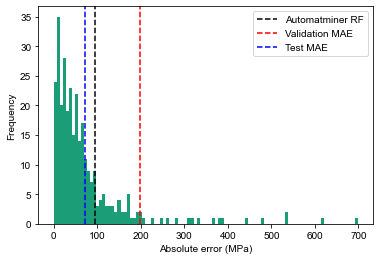

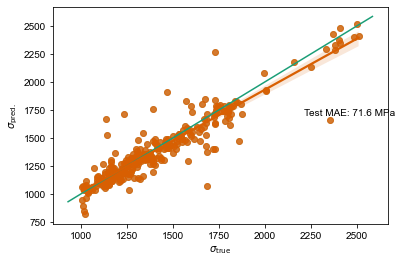

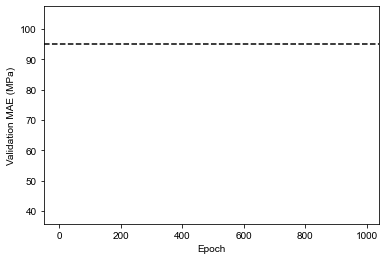

In [14]:
model = MODNetModel(
    [[["sigma"]]], 
    {"sigma": 1}, 
)

model.fit_preset(data)
benchmark(model, data)